# Pruebas

+ En las definiciones de las funciones en LennardGas ya no se suponen valores predeterminados para los parámetros, siempre hay que darlos explicitamente para realizar pruebas.

In [1]:
using PyPlot

In [2]:
push!(LOAD_PATH, pwd())
using LennardGas
using Colors

In [3]:
#Parámetros
r_c = 2.5
L   = r_c * 10
cajitas = 2^60
h = 0.005

particulas = 10

10

In [4]:
#Condición inicial (en Float64)
inicial = randn(3*particulas) .+ 10.0
segundo = fluctuacion_gaussiana(inicial, 0.1);

In [5]:
#Condición inicial (en Int64)
X0 = flotante_a_entero(inicial, L, cajitas)
X1 = flotante_a_entero(segundo, L, cajitas);

In [8]:
@time vector_fuerzas(X0 , L, cajitas, r_c, h);

  0.000438 seconds (2.24 k allocations: 138.313 KB)


In [9]:
@time X2 = paso_verlet(X0, X1, L, cajitas, r_c, h);

  0.000420 seconds (2.20 k allocations: 137.750 KB)


In [10]:
X_0 = paso_verlet(X2, X1, L, cajitas, r_c, h);
X0 == X_0

true

#### MUY poco reversible por ahora...

In [11]:
pasos = 10
@time registro = evolucion(X0, X1, pasos, L, cajitas, r_c, h)

12x30 Array{Int64,2}:
 511057286788400832  450935928013989120  …  472749159068292928
 506477469792136000  457423013868228224     483876053585224192
 501832479641302494  463820411565261010     495004558692050504
 497212589209928426  470105214207935555     506133750123672869
 492588625351234895  476392167460521751     517263221463781869
 487965077636863215  482679172584819459  …  528392798383482133
 483342099992064911  488966171698159009     539522375303182397
 478719402896523177  495253210959250799     550651952222882661
 474096743824993285  501540317484385810     561781529142582925
 469473978842657623  507827497029240477     572911106062283189
 464851068875864235  514114737170817571  …  584040709079284192
 460228013990124986  520402024505039603     595170312096285195

0.474255 seconds (107.36 k allocations: 5.539 MB)


In [12]:
function prueba_reversible(X0, X1, pasos, L, cajitas, r_c, h) 
    #Se puede hacer sin guardar todos los intermediarios...
    
    registro_ida = evolucion(X0, X1, pasos, L, cajitas, r_c, h)
    X_ultima = collect(registro_ida[end,:])
    X_penultima = collect(registro_ida[end-1,:])

    registro_vuelta = evolucion(X_ultima, X_penultima, pasos, L, cajitas, r_c, h)
    X_original = collect(registro_vuelta[end,:])

    X0 == X_original , registro_ida, registro_vuelta
end

prueba_reversible (generic function with 1 method)

In [23]:
pasos = 100000

prueba1 = prueba_reversible(X0, X1, pasos, L, cajitas, r_c, h)
prueba1[1]

true

In [14]:
prueba1[2]

3x30 Array{Int64,2}:
 511057286788400832  450935928013989120  …  472749159068292928
 506477469792136000  457423013868228224     483876053585224192
 501832479641302494  463820411565261010     495004558692050504

In [15]:
prueba1[3]

3x30 Array{Int64,2}:
 501832479641302494  463820411565261010  …  495004558692050504
 506477469792136000  457423013868228224     483876053585224192
 511057286788400832  450935928013989120     472749159068292928

**Algo anda muy mal**

In [13]:
pasos = 2

prueba2 = prueba_reversible(X0, X1, pasos, L, cajitas, r_c, h)
prueba2[1]

false

### Graficando

In [18]:
function dibujante(registro::Matrix{Int64}, tiempo::Int64)
    
    if 0 > tiempo > size(registro, 2)
        return println("El tiempo solicitado no se encuentra disponible en el registro dado.")
    end
    
    N = size(registro, 1)÷3 #Funciona si el número de entradas es múltiplo de 3
    x = zeros(N)
    y = zeros(N)
    z = zeros(N)
    
    coord = registro[tiempo, :]
    paleta = distinguishable_colors(N)
    for i in 1:N
        tinta = paleta[i]
        x = collect(coord[3i-2])
        y = collect(coord[3i-1])
        z = collect(coord[3i])
        plot3D(x, y, z, marker = "o", color = (tinta.r, tinta.g, tinta.b))
    end
end

dibujante (generic function with 1 method)

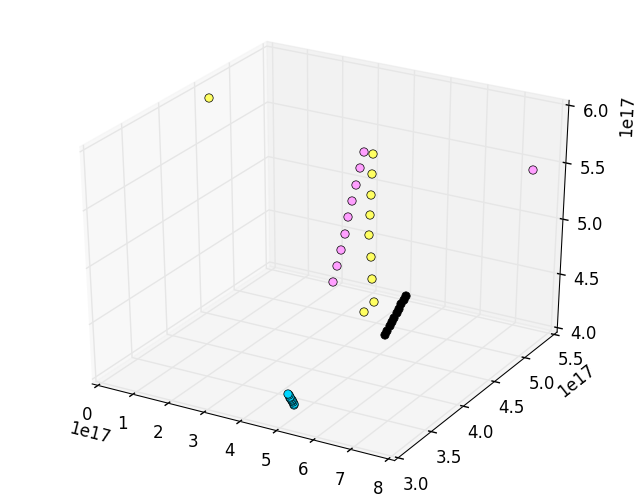

In [21]:
paso_temp = 10
for t in 1:paso_temp
    dibujante(registro, t)
end
#axis("off")

**Parece como si el error estuviera en la forma como se calculan las fuerzas**